# Training a Hierarchical DivNoising network for BSD68 dataset corrupted with Gaussian noise

In [1]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import math
import torch
import random
import sys
sys.path.append('../../../')
from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training
import glob
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import urllib
import os
import zipfile

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### Download data
Data will be downloaded and stored in the directory ```data```. This data was also used in this [paper](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf) and many others.

In [3]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/BSD68_reproducibility.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/pbj89sV6n6SyM29/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

# Training Data Preparation

For training we need to follow some preprocessing steps first which will prepare the data for training purposes.
We start by reading the training and validation data first from ```data``` folder. 

In [4]:
train_data = np.load('data/BSD68_reproducibility_data/train/DCNN400_train_gaussian25.npy')
val_data = np.load('data/BSD68_reproducibility_data/val/DCNN400_validation_gaussian25.npy')

We specify the std of Gaussian noise given by ```gaussian_noise_std``` parameter in the next cell. For this dataset, it is 25.

In [5]:
gaussian_noise_std = 25

In [6]:
### We extract overlapping patches of size ```patch_size x patch_size``` from training and validation images.
### Usually 128x128 patches work well for most natural image datasets
patch_size = 128

In [7]:
img_width = train_data.shape[2]
img_height = train_data.shape[1]
num_patches = int(float(img_width*img_height)/float(patch_size**2)*2)
train_images = utils.extract_patches(train_data, patch_size, num_patches)
val_images = utils.extract_patches(val_data, patch_size, num_patches)
train_images = utils.augment_data(train_images) 
test_images = val_images[:100]
img_shape = (train_images.shape[1], train_images.shape[2])
print("Shape of training images:", train_images.shape, "Shape of validation images:", val_images.shape)

100%|██████████| 4/4 [00:00<00:00, 2745.86it/s]


Raw image size after augmentation (76032, 128, 128)
Shape of training images: (76032, 128, 128) Shape of validation images: (12, 128, 128)


# Configure Hierarchical DivNoising Model

<code>model_name</code> specifies the name of the model with which the weights will be saved and wil be loaded later for prediction.<br>
<code>directory_path</code> specifies the directory where the model weights and the intermediate denoising and generation results will be saved. <br>
<code>noiseModel</code> specifies a noise model for training. If noisy data is generated synthetically using Gaussian noise, set it to None.<br>
<code>batch_size</code> specifies the batch size used for training. The default batch size of $16$ works well for most natural image datasets.<br>
<code>virtual_batch</code> specifies the virtual batch size used for training. It divides the <code>batch_size</code> into smaller mini-batches of size <code>virtual_batch</code>. Decrease this if batches do not fit in memory.<br>
<code>test_batch_size</code> specifies the batch size used for testing every $1000$ training steps. Decrease this if test batches do not fit in memory, it does not have any consequence on training. It is just for intermediate visual debugging.<br>
<code>lr</code> specifies the learning rate.<br>
<code>max_epochs</code> specifies the total number of training epochs. Around $150-200$ epochs work well generally.<br>
<code>steps_per_epoch</code> specifies how many steps to take per epoch of training. Around $500$ steps work well for most natural image datasets.<br>
<code>num_latents</code> specifies the number of stochastic layers. The default setting of $6$ works well for most datasets but quite good results can also be obtained with as less as $4$ layers. However, more stochastic layers may improve performance for some datasets at the cost of increased training time.<br>
<code>z_dims</code> specifies the number of bottleneck dimensions (latent space dimensions) at each stochastic layer per pixel. The default setting of $32$ works well for most datasets.<br>
<code>blocks_per_layer</code> specifies how many residual blocks to use per stochastic layer. Usually, setting it to be $4$ or more works well. However, more residual blocks improve performance at the cost of increased training time.<br>
<code>batchnorm</code> specifies if batch normalization is used or not. Turning it to True is recommended.<br>
<code>free_bits</code> specifies the threshold below which KL loss is not optimized for. This prevents the [KL-collapse problem](https://arxiv.org/pdf/1511.06349.pdf%3Futm_campaign%3DRevue%2520newsletter%26utm_medium%3DNewsletter%26utm_source%3Drevue). The default setting of $1.0$ works well for most datasets.<br>

**__Note:__** With these settings, training will take approximately $12$ hours on Tesla P100/Titan Xp GPU needing less than 6 GB GPU memory. We optimized the code to run on less GPU memory. For faster training, consider increasing ```virtual_batch_size``` but since we have not tested with different settings of ```virtual_batch_size```, we do not yet know how this affects results. To reduce traing time, also consider reducing either ```num_latents``` or ```blocks_per_layer``` to $4$. These settings will bring down the training time even more.

In [8]:
model_name = "natural"
directory_path = "./Trained_model/" 
noiseModel = None

# Training-specific
batch_size=16
virtual_batch = 8
lr=3e-4
max_epochs = 100
steps_per_epoch = 500
test_batch_size=100

# Model-specific
num_latents = 6
z_dims = [32]*int(num_latents)
blocks_per_layer = 5
batchnorm = True
free_bits = 1.0

# Train Hierarchical DivNoising Model

In [ ]:
train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager(train_images,val_images,
                                                                                           test_images,batch_size,
                                                                                           test_batch_size)

model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,
                  data_mean=data_mean,data_std=data_std,
                  noiseModel=noiseModel,device=device,batchnorm=batchnorm,
                  free_bits=free_bits,img_shape=img_shape).cuda()

model.train() # Model set in training mode

training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,
                           directory_path=directory_path,train_loader=train_loader,val_loader=val_loader,
                           test_loader=test_loader,virtual_batch=virtual_batch,
                           gaussian_noise_std=gaussian_noise_std,model_name=model_name)

# Plotting Losses

In [9]:
trainHist=np.load(directory_path+"model/train_loss.npy")
reconHist=np.load(directory_path+"model/train_reco_loss.npy")
klHist=np.load(directory_path+"model/train_kl_loss.npy")
valHist=np.load(directory_path+"model/val_loss.npy")

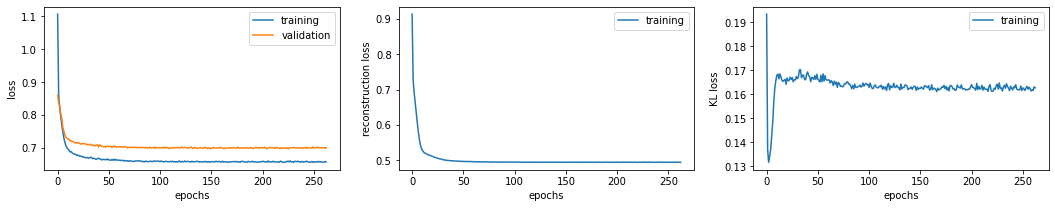

In [10]:
plt.figure(figsize=(18, 3))
plt.subplot(1,3,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()
plt.show()